###  MicroGrad demo

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

2024-05-25 11:22:08.270307: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
np.random.seed(1337)
random.seed(1337)

In [4]:
# Загрузка данных MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Преобразование данных в формат float32
x_train = x_train.astype('float64') / 255.0 * 2 - 1
x_test = x_test.astype('float64') / 255.0 * 2 - 1

# Изменение формы данных
x_train = x_train.reshape(x_train.shape[0], 784, 1)
x_test = x_test.reshape(x_test.shape[0], 784, 1)

# One-hot кодирование меток
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes=10)

y_train_oh = y_train_oh * 2 - 1
y_test_oh = y_test_oh * 2 - 1

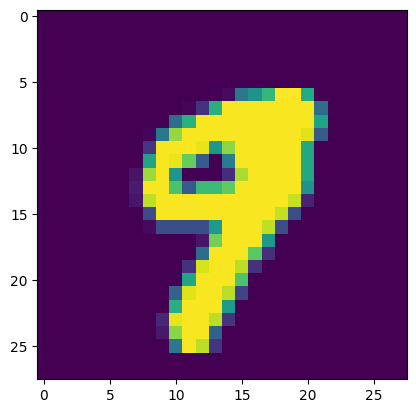

In [5]:
def draw_some(numbers):
    number = numbers[random.randint(0, numbers.shape[0] - 1)]
    plt.imshow(number.reshape([28, 28]))

draw_some(x_train)

In [92]:
positive_class = 0

# Создание массива меток для обучающего набора
y_train_bin = np.ones(y_train.shape) * -1
# Установка меток позитивного класса
y_train_bin[y_train == positive_class] = 1
# Создание массива меток для тестового набора
y_test_bin = np.ones(y_test.shape) * -1
# Установка меток позитивного класса
y_test_bin[y_test == positive_class] = 1

y_test_bin

array([-1., -1., -1., ..., -1., -1., -1.])

In [121]:
from collections import defaultdict

POSITIVE_CLASSES = [0, 1]

def balance(x, y, positive_classes):
    assert -1 not in positive_classes

    p_idx = np.where(np.isin(y, positive_classes))[0]
    n_idx = np.where(~np.isin(y, positive_classes))[0]
    len = min(p_idx.shape[0], n_idx.shape[0])
    p_idx = np.random.permutation(p_idx)[:len]
    n_idx = np.random.permutation(n_idx)[:len]
    idx = np.random.permutation(np.concatenate([p_idx, n_idx]))
    x, y = x[idx], y[idx]

    return x, y

X, Y = balance(x_train, y_train, POSITIVE_CLASSES)

def oh_encode(y, positive_classes):
    gray = np.array([0] * len(positive_classes))
    oh_enc = defaultdict(lambda: gray)
    oh_dec = defaultdict(lambda: None)
    for i, cls in enumerate(positive_classes):
        cls_vec = np.array([-1.0] * len(positive_classes))
        cls_vec[i] = 1.0
        oh_enc[cls] = cls_vec
        oh_dec[tuple(cls_vec)] = cls

    return oh_dec, np.array([oh_enc[cls] for cls in y])

OH_DEC, Y_oh = oh_encode(Y, POSITIVE_CLASSES)
OH_DEC, Y_oh.shape

(defaultdict(<function __main__.oh_encode.<locals>.<lambda>()>,
             {(1.0, -1.0): 0, (-1.0, 1.0): 1}),
 (25330, 2))

In [114]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

# initialize a model
model = MLP(784, [1], act='tanh')
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [linear-Neuron(784)]]
number of parameters 785


In [44]:


x_train_mg = [list(map(Value, x)) for x in x_train]

KeyboardInterrupt: 

In [ ]:
np.random.permutation(x_train)

In [16]:
# loss function
def loss(batch_size=None):

    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]

    # forward the model to get scores
    scores = list(map(model, inputs))

    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss

    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
total_loss.backward()
model.init_lr()

print(total_loss, acc, len(model.parameters()))

Value(data=2.5534797926259576, min=-2.5534797926259576, space=5.106959585251915, pgrad=0.0, grad=1, lr=1.0) 0.22 585


In [31]:
# optimization
for k in range(1000):

    # forward
    total_loss, acc = loss()
    print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

    # backward
    model.zero_grad()
    total_loss.backward()

    # update (sgd)
    # learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.learn(0.5)

    # if model.freeze():
    #    print('Early Stop by FREEZE!')
    #    break

total_loss, acc = loss()
model.zero_grad()
total_loss.backward()
print(f"final loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 0.11251487635764759, accuracy 100.0%
step 1 loss 0.11250084595706551, accuracy 100.0%
step 2 loss 0.11248108089780494, accuracy 100.0%
step 3 loss 0.112454180633874, accuracy 100.0%
step 4 loss 0.11241597011896379, accuracy 100.0%
step 5 loss 0.11236250413176409, accuracy 100.0%


In [28]:
parameters = model.parameters()
parameters.sort(key=lambda p: p.space)
parameters

[Value(data=-1.9947487869584002, min=-3.4590379343600643, space=2, pgrad=0.3164385103299193, grad=-0.00039894975739168003, lr=4.7066051919023064e-23),
 Value(data=-1.0728014245228457, min=-1.4142135623730951, space=2, pgrad=1.7715171701469206, grad=-0.00021456028490456915, lr=2.5744375554590955e-32),
 Value(data=-2.7157169718639618, min=-2.9725728497443797, space=2, pgrad=0.02045823305768263, grad=-0.0005431433943727924, lr=1.3147750239723276e-14),
 Value(data=-1.7970310290284839, min=-2.8349879125417203, space=2, pgrad=-0.5661779339223949, grad=-0.0003594062058056968, lr=7.878201547692977e-15),
 Value(data=-1.8705988839463523, min=-1.8974781278126973, space=2, pgrad=-0.49911022189387255, grad=-0.0003741197767892705, lr=9.872487092988199e-18),
 Value(data=0.40348376766594174, min=-1, space=2, pgrad=0.03747637614297948, grad=8.069675353318835e-05, lr=4.107237878522245e-28),
 Value(data=-0.6695670617533066, min=-1, space=2, pgrad=-0.03752959280179696, grad=-0.00013391341235066134, lr=3.3

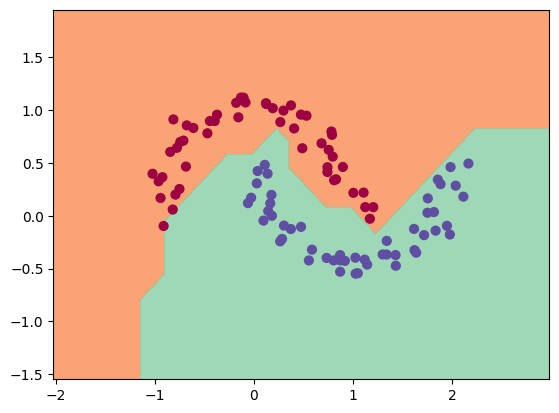

In [30]:
visual()

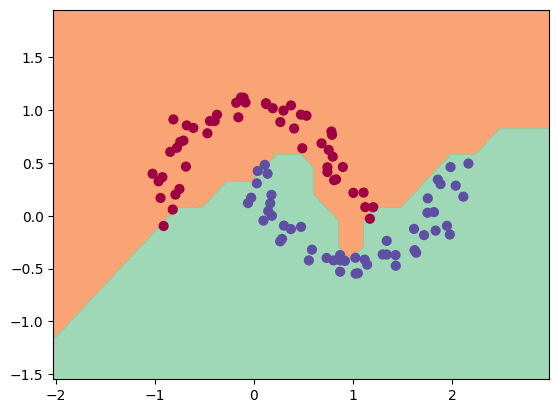

In [26]:
# visualize decision boundary
def visual():
    h = 0.25
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    Xmesh = np.c_[xx.ravel(), yy.ravel()]
    inputs = [list(map(Value, xrow)) for xrow in Xmesh]
    scores = list(map(model, inputs))
    Z = np.array([s.data > 0 for s in scores])
    Z = Z.reshape(xx.shape)

    fig = plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

visual()

# tanh

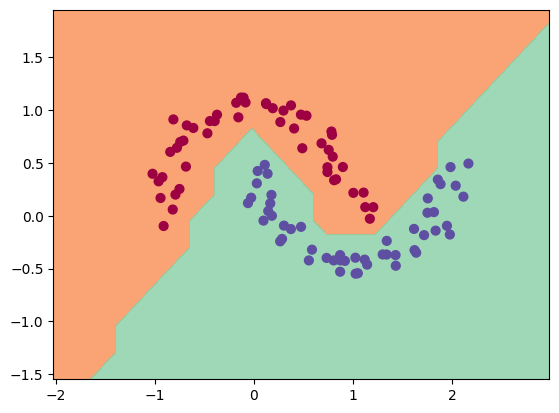

In [8]:
visual()

# relu

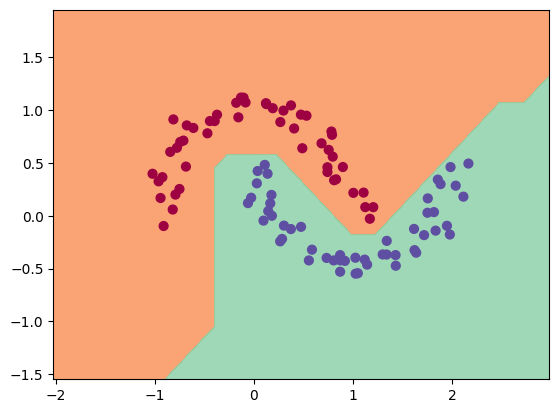

In [12]:
visual()

# tanh with dynamic learning rate <0.5, 1.1>

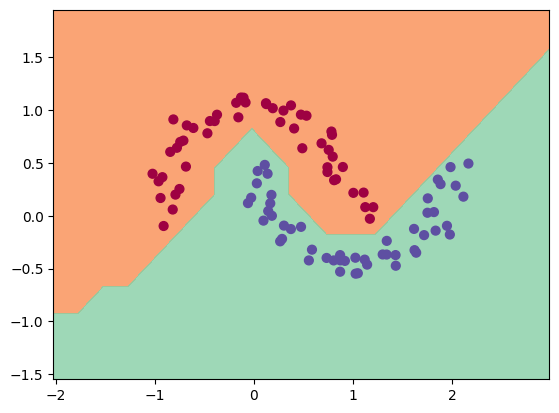

In [8]:
visual()

# relu with dynamic learning rate <0.5, 1.1>

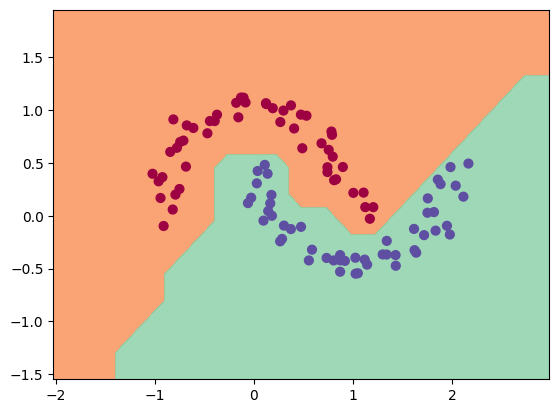

In [22]:
visual()